# Introduction:
- The sinking of the Titanic is one of the most infamous shipwrecks in history.
- On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
- While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [12]:
train.shape

(891, 12)

In [13]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [14]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='count'>

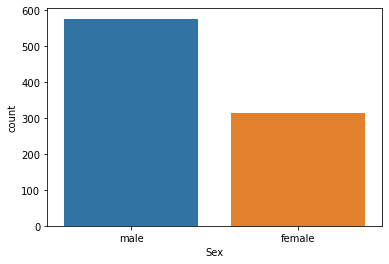

In [16]:
sns.countplot(x='Sex',data=train) 

<AxesSubplot:xlabel='Age', ylabel='count'>

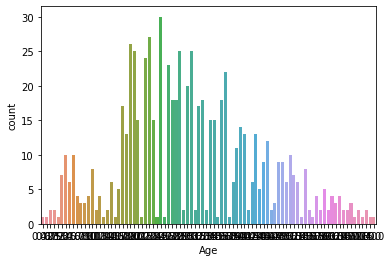

In [17]:
sns.countplot(x='Age',data=train)

<AxesSubplot:xlabel='Ticket', ylabel='count'>

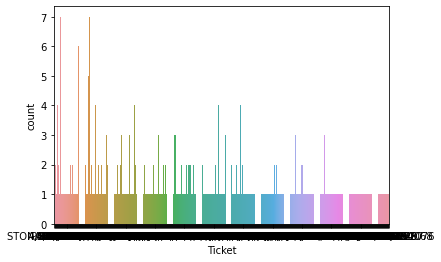

In [18]:
sns.countplot(x='Ticket',data=train)

In [3]:
def process_data(df, name='X'):
    temp = df.copy().drop(columns=['PassengerId'], axis=1)
    temp['Sex'] = temp['Sex'].apply(lambda x: 0 if x == 'male' else 1)
    temp['Age'] = temp[['Age', 'Pclass']].groupby('Pclass').transform(lambda x: x.fillna(x.mean()))
    temp['Embarked'] = temp['Embarked'].fillna(value=temp['Embarked'].mode())
    temp['Fare'] = temp[['Fare', 'Pclass']].groupby('Pclass').transform(lambda x: x.fillna(x.mean()))
    temp = pd.merge(temp.drop(columns=['Pclass'], axis=1), pd.get_dummies(temp['Pclass'], prefix='Pclass'),
                    how='left', left_index=True, right_index=True)
    temp = pd.merge(temp.drop(columns=['Embarked'], axis=1), pd.get_dummies(temp['Embarked'], prefix='Embarked'),
                    how='left', left_index=True, right_index=True)
    temp['Name Length'] = temp['Name'].str.len()
    temp['Party Size'] = (temp['SibSp'] + temp['Parch'])
    temp['Married Woman'] = np.where(temp['Sex'] == 1, np.where(temp['Name'].str.contains('Mrs'), 1, 0), 0)
    if name == 'X':
        return temp[['Sex', 'Age', 'Party Size', 'Name Length', 'Married Woman', 'SibSp', 'Parch', 'Fare',
                     'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
    else:
        return temp[['Survived']]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(process_data(train, name='X'), process_data(train, name='Y'),
                                                    train_size=0.7, stratify=process_data(train, name='Y'))

In [5]:
svc_param_search = {'clf__C': [pow(2, -10 + i*2) for i in range(0, 15)], 'clf__gamma': [pow(2, -17 + i*2) for i in range(0, 15)]}
svc_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(probability=True))])
svc_clf = GridSearchCV(estimator=svc_pipeline, scoring='accuracy', param_grid=svc_param_search, verbose=0)
rf_param_search = {'clf__n_estimators': np.arange(100, 1800, 20), 'clf__max_depth': np.arange(2, 14),
                   'clf__min_samples_split': np.arange(2, 17), 'clf__min_samples_leaf': np.arange(1, 12)}
rf_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('clf', RandomForestClassifier())])
rf_clf = RandomizedSearchCV(estimator=rf_pipeline, scoring='accuracy', n_iter=50, param_distributions=rf_param_search, verbose=0)
knn_param_search = {'clf__n_neighbors': np.arange(1, 21, 1), 'clf__leaf_size': np.arange(10, 51, 1),
                    'clf__p': np.arange(1, 3)}
knn_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])
knn_clf = RandomizedSearchCV(estimator=knn_pipeline, scoring='accuracy', n_iter=750, param_distributions=knn_param_search, verbose=0)

In [6]:
ensemble_clf = VotingClassifier(estimators=[('svc', svc_clf), ('rf', rf_clf), ('knn', knn_clf)], voting='soft')
ensemble_clf.fit(X_train, y_train.values.ravel())
for estimator in ensemble_clf.estimators_:
    print('Est: {}, Score: {:.2%}'.format(estimator.best_estimator_._final_estimator, estimator.best_score_))

Est: SVC(C=262144, gamma=0.0001220703125, probability=True), Score: 84.43%
Est: RandomForestClassifier(max_depth=5, min_samples_split=16, n_estimators=980), Score: 84.11%
Est: KNeighborsClassifier(leaf_size=38, n_neighbors=12), Score: 81.86%


In [7]:
predictions = pd.merge(test[['PassengerId']], pd.DataFrame(ensemble_clf.predict(process_data(test, name='X')), columns=['Survived']),
                       how='left', left_index=True, right_index=True)
predictions

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Conclusion:
Hence, the accuracy of svc is more, this model is used to build the model.